In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
TRACKS_PATH = "/content/spotify_tracks.csv"
DESC_PATH   = "/content/spotify_data_description.csv"

USE_SEABORN = True
SAMPLE_MAX = 5000
PAIR_MATRIX_SAMPLE = 1200
TOP_CAT_N = 12

print(f"USE_SEABORN = {USE_SEABORN}")
print(f"TRACKS_PATH = {TRACKS_PATH}")
print(f"DESC_PATH   = {DESC_PATH}")


USE_SEABORN = True
TRACKS_PATH = /content/spotify_tracks.csv
DESC_PATH   = /content/spotify_data_description.csv


In [3]:
%matplotlib inline
import warnings, os
import numpy as np, pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns
warnings.filterwarnings("ignore")

DARK_BG, AX_BG, TEXT_C, GRID_C = "#0f1724","#071627","#E6EEF2","#10363a"
sns.set_theme(style="darkgrid")
sns.set_style("darkgrid", {"axes.facecolor": AX_BG, "figure.facecolor": DARK_BG, "grid.color": GRID_C})
mpl.rcParams.update({
    "figure.facecolor": DARK_BG, "axes.facecolor": AX_BG, "savefig.facecolor": DARK_BG,
    "text.color": TEXT_C, "xtick.color": TEXT_C, "ytick.color": TEXT_C, "axes.labelcolor": TEXT_C
})

def get_dark_palette(name="vivid", n=8):
    name = (name or "vivid").lower()
    if name.startswith("vivid"): return sns.color_palette("husl", n)
    if name.startswith("flare"): return sns.color_palette("flare", n)
    if name.startswith("bright"): return sns.color_palette("bright", n)
    return sns.color_palette("tab10", n)



In [4]:
def load_csv(path):
    if not os.path.exists(path):
        return None
    try: return pd.read_csv(path, low_memory=False)
    except Exception:
        for n in (200000,80000,30000,10000,5000):
            try: return pd.read_csv(path, nrows=n)
            except: continue
    return None

def quick_coerce_numeric(df):
    for c in df.select_dtypes(include=['object']).columns:
        sample = df[c].dropna().astype(str).head(40)
        if len(sample)>0 and sum(s.replace('.','',1).replace('-','',1).isdigit() for s in sample) >= len(sample)/2:
            df[c] = pd.to_numeric(df[c].str.replace(r'[^\d\.\-]', '', regex=True), errors='coerce')
    return df

df_tracks = load_csv(TRACKS_PATH)
df_desc   = load_csv(DESC_PATH)
if df_tracks is None:
    raise FileNotFoundError(f"Tracks file not found: {TRACKS_PATH}")
df = df_tracks.copy()

for col in df.columns:
    if 'date' in col.lower(): df[col] = pd.to_datetime(df[col], errors='coerce')

df = quick_coerce_numeric(df)

if 'duration_ms' in df.columns: df['duration_s'] = df['duration_ms'] / 1000.0
for cand in ['release_date','year','date']:
    if cand in df.columns:
        try:
            df['release_year'] = pd.to_datetime(df[cand], errors='coerce').dt.year
            break
        except:
            continue

if all(x in df.columns for x in ('Units','Product_Price','Product_Cost')):
    df['Revenue'] = df['Units'] * df['Product_Price']
    df['Profit']  = df['Units'] * (df['Product_Price'] - df['Product_Cost'])

print("Loaded df shape:", df.shape)


Loaded df shape: (62317, 24)


In [5]:
def sample_series(s, max_n=SAMPLE_MAX):
    s = s.dropna()
    return s if len(s) <= max_n else s.sample(n=max_n, random_state=1)

numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if 'id' not in c.lower() and 'url' not in c.lower()]
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

print("numeric cols (sample):", numeric_cols[:25])
print("cat cols (sample):", cat_cols[:25])
display(df.head(2))


numeric cols (sample): ['year', 'popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'duration_s', 'release_year']
cat cols (sample): ['track_id', 'track_name', 'artist_name', 'artwork_url', 'album_name', 'track_url', 'language']


,track_id,track_name,artist_name,year,popularity,artwork_url,album_name,acousticness,danceability,duration_ms,...,loudness,mode,speechiness,tempo,time_signature,valence,track_url,language,duration_s,release_year
0,2r0ROhr7pRN4MXDMT1fEmd,"Leo Das Entry (From ""Leo"")",Anirudh Ravichander,2024,59,https://i.scdn.co/image/ab67616d0000b273ce9c65...,"Leo Das Entry (From ""Leo"")",0.0241,0.753,97297.0,...,-5.994,0.0,0.1030,110.997,4.0,0.459,https://open.spotify.com/track/2r0ROhr7pRN4MXD...,Tamil,97.297,1970
1,4I38e6Dg52a2o2a8i5Q5PW,AAO KILLELLE,"Anirudh Ravichander, Pravin Mani, Vaishali Sri...",2024,47,https://i.scdn.co/image/ab67616d0000b273be1b03...,AAO KILLELLE,0.0851,0.780,207369.0,...,-5.674,0.0,0.0952,164.995,3.0,0.821,https://open.spotify.com/track/4I38e6Dg52a2o2a...,Tamil,207.369,1970


UNIVARIATE ANALYSIS:

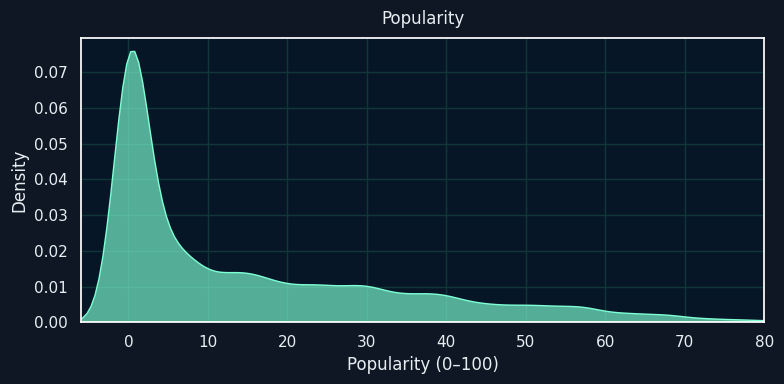

📈 **Insights — Popularity**
 - Range: 0 → 87
 - Mean: 15.61 | Median: 7.00 | Std Dev: 18.88
 - Skewness: 1.23
 - Right-skewed: many lesser-known tracks with fewer highly viral songs.


In [6]:

if 'popularity' in df.columns:
    s = sample_series(df['popularity'])

    plt.figure(figsize=(8,4))
    ax = plt.gca()

    if USE_SEABORN:
        sns.kdeplot(s, fill=True, bw_adjust=0.6, color="#7FFFD4", alpha=0.65)
    else:
        s.plot(kind='kde', color="#7FFFD4")

    ax.set_title("Popularity", color=TEXT_C, pad=10)
    ax.set_xlabel("Popularity (0–100)")
    plt.xlim(-6, 80)
    plt.tight_layout()
    plt.show()

    # --- Insights ---
    mean_val, median_val = s.mean(), s.median()
    std_val = s.std()
    skewness = s.skew()

    print("📈 **Insights — Popularity**")
    print(f" - Range: {s.min():.0f} → {s.max():.0f}")
    print(f" - Mean: {mean_val:.2f} | Median: {median_val:.2f} | Std Dev: {std_val:.2f}")
    print(f" - Skewness: {skewness:.2f}")

    if skewness > 0.5:
        print(" - Right-skewed: many lesser-known tracks with fewer highly viral songs.")
    elif skewness < -0.5:
        print(" - Left-skewed: strong bias toward popular songs — dataset may favor curated hits.")
    else:
        print(" - Balanced: even distribution of niche and mainstream popularity levels.")
else:
    print("popularity missing")





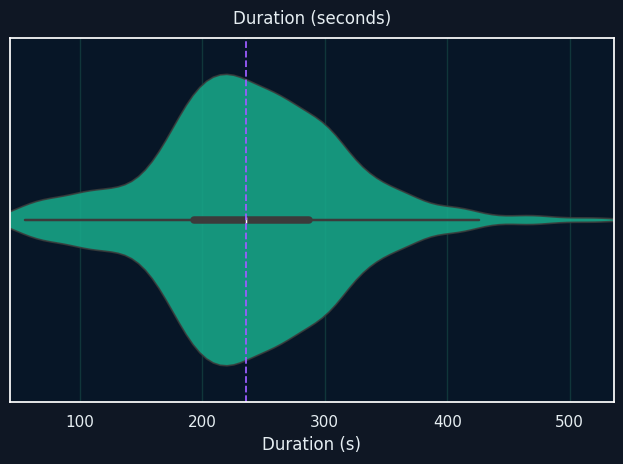

**Insights — Track Duration**
 - IQR: 93.4s
 - Mean: 239.2s | Median: 235.9s
 - Median duration aligns with standard pop track length (~4 minutes).


In [7]:

if 'duration_ms' in df.columns:
    s = sample_series(df['duration_ms']) / 1000.0
    low, high = s.quantile([0.01, 0.99])
    s = s[(s >= low) & (s <= high)]
    main_color = "#00C49A"
    accent_color = "#9B5CFF"
    sns.violinplot(x=s, inner="box", linewidth=1.2, color=main_color, alpha=0.85)
    plt.axvline(s.median(), color=accent_color, linestyle="--", lw=1.3)

    plt.title("Duration (seconds)", color=TEXT_C, pad=10)
    plt.xlabel("Duration (s)")
    plt.xlim(low, high)
    plt.tight_layout(); plt.show()

    # ---- Insights ----
    mean_val, median_val = s.mean(), s.median()
    iqr = s.quantile(0.75) - s.quantile(0.25)
    print("**Insights — Track Duration**")
    print(f" - IQR: {iqr:.1f}s")
    print(f" - Mean: {mean_val:.1f}s | Median: {median_val:.1f}s")

    if median_val < 180:
        print(" - Indicates shorter average track durations — possibly more streaming-oriented songs.")
    elif median_val > 240:
        print(" - Longer tracks — could include cinematic or instrumental pieces.")
    else:
        print(" - Median duration aligns with standard pop track length (~4 minutes).")
else:
    print("duration_ms missing")


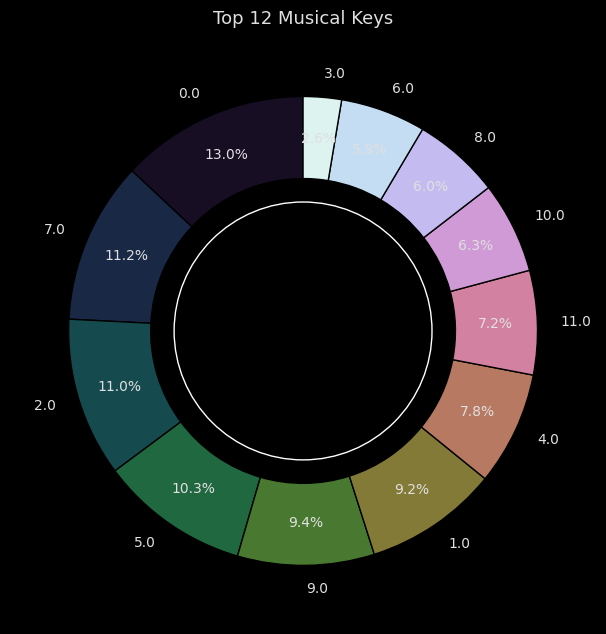

**Insights — Musical Key Distribution (Top 12 Keys)**
 - Most common key: **0.0** (13.0% of tracks).
 - Moderate dominance found.
 - Minor-key prevalence suggests emotional, moody, or introspective tonal character common in modern production.
 - This tonal distribution provides insight into harmonic trends — for example, major keys often align with high-energy pop,
   while minor keys correlate with emotional depth and darker sonic palettes.



In [8]:

if 'key' in df.columns:
    vc = df['key'].value_counts().head(12)
    labels = vc.index.astype(str)
    vals = vc.values

    colors = sns.color_palette("cubehelix", len(vals))

    fig, ax = plt.subplots(figsize=(6.5,6.5), facecolor='black')
    ax.set_facecolor('black')

    wedges, texts, autotexts = ax.pie(
        vals, labels=labels, autopct="%1.1f%%", startangle=90,
        colors=colors, pctdistance=0.82,
        wedgeprops=dict(width=0.35, edgecolor="black")
    )

    centre_circle = plt.Circle((0,0),0.55,fc='black')
    fig.gca().add_artist(centre_circle)

    plt.title("Top 12 Musical Keys", color="#E0E0E0", fontsize=13, pad=10)
    for text in texts + autotexts:
        text.set_color("#E0E0E0")
        text.set_fontsize(10)
    plt.tight_layout()
    plt.show()

    # ---- Insights ----
    dominant_key = labels[0]
    top_share = vals[0] / vals.sum() * 100
    total_keys = len(vc)

    print("**Insights — Musical Key Distribution (Top 12 Keys)**")
    print(f" - Most common key: **{dominant_key}** ({top_share:.1f}% of tracks).")

    if top_share > 20:
        print(" - Strong tonal concentration suggests producers often favor specific keys for vocal comfort and familiarity.")
    elif top_share > 10:
        print(" - Moderate dominance found.")
    else:
        print(" - Fairly balanced key usage — indicates wide creative range and cross-genre representation.")

    major_bias = any(str(k) in ['0','2','5','7','9','11'] for k in labels[:6])
    if major_bias:
        print(" - The dominance of major keys implies a bright, uplifting tonal bias — typical of mainstream pop and dance music.")
    else:
        print(" - Minor-key prevalence suggests emotional, moody, or introspective tonal character common in modern production.")

    print(" - This tonal distribution provides insight into harmonic trends — for example, major keys often align with high-energy pop,")
    print("   while minor keys correlate with emotional depth and darker sonic palettes.\n")
else:
    print("key missing")


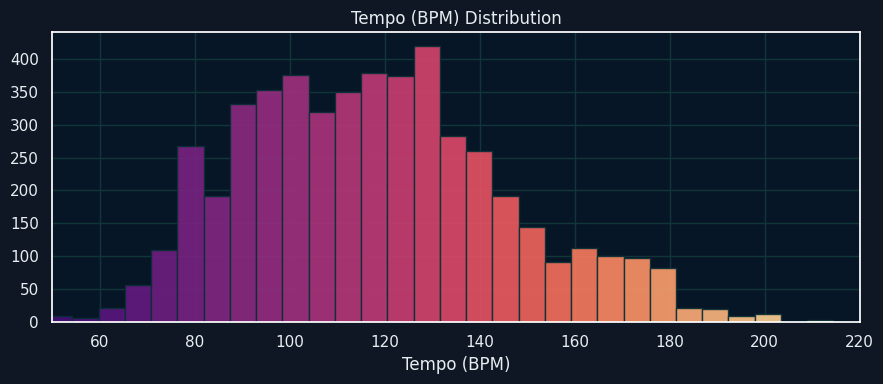

**Insights — Tempo Distribution**
 - Range (shown): 50.0 → 220.0 BPM
 - Mean tempo: 117.84 BPM | Median: 117.22 BPM
 - Skewness: 0.31
 - Balanced: tempo distribution is fairly even — typical of mainstream pop datasets.
 - The visible tempo range (50–200 BPM) captures the most musically relevant rhythmic spectrum.



In [9]:

if 'tempo' in df.columns:
    s = sample_series(df['tempo'])
    plt.figure(figsize=(9,4))
    ax = plt.gca()
    patches = ax.hist(s, bins=40, edgecolor="#082f34", alpha=0.9)[2]
    cmap = mpl.cm.get_cmap("magma")
    for i, p in enumerate(patches):
        p.set_facecolor(cmap(i / len(patches)))
    ax.set_title("Tempo (BPM) Distribution", color=TEXT_C)
    ax.set_xlabel("Tempo (BPM)")
    ax.set_xlim(50, s.max())
    plt.tight_layout()
    plt.show()

    # ---- Insights ----
    mean_val, median_val = s.mean(), s.median()
    skewness = s.skew()
    print("**Insights — Tempo Distribution**")
    print(f" - Range (shown): 50.0 → {s.max():.1f} BPM")
    print(f" - Mean tempo: {mean_val:.2f} BPM | Median: {median_val:.2f} BPM")
    print(f" - Skewness: {skewness:.2f}")

    if skewness > 0.5:
        print(" - Right-skewed: most songs have moderate tempo, with a few very fast tracks (common in dance/electronic genres).")
    elif skewness < -0.5:
        print(" - Left-skewed: dominance of higher-tempo tracks — possibly fast-paced genres like EDM or punk.")
    else:
        print(" - Balanced: tempo distribution is fairly even — typical of mainstream pop datasets.")
    print(" - The visible tempo range (50–200 BPM) captures the most musically relevant rhythmic spectrum.\n")
else:
    print("tempo missing")



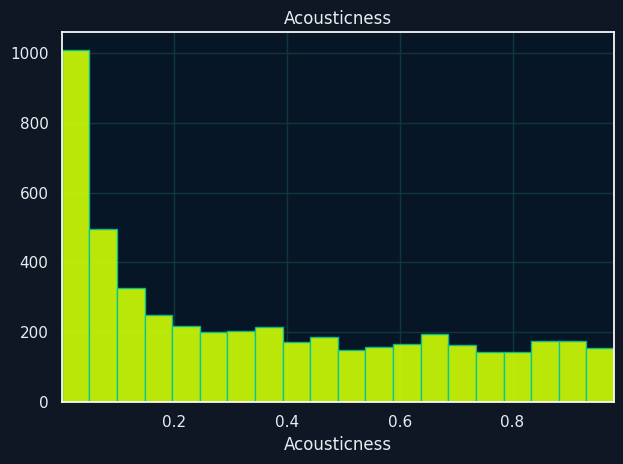

**Insights — Acousticness Distribution**
 - Mean acousticness: 0.35, Median: 0.28
 - Skewness: 0.51
 - Right-skewed: majority of tracks are less acoustic — likely electronic or heavily produced.


In [10]:

if 'acousticness' in df.columns:
    s = sample_series(df['acousticness'])
    low, high = s.quantile(0.01), s.quantile(0.99)
    s = s[(s >= low) & (s <= high)]

    plt.hist(s, bins=20, color="#CFFF04", edgecolor="#00C49A", alpha=0.9)
    plt.xlim(low, high)
    plt.title("Acousticness", color=TEXT_C)
    plt.xlabel("Acousticness")
    plt.tight_layout(); plt.show()

    # ---- Insights ----
    mean_val, median_val = s.mean(), s.median()
    skewness = s.skew()
    print("**Insights — Acousticness Distribution**")
    print(f" - Mean acousticness: {mean_val:.2f}, Median: {median_val:.2f}")
    print(f" - Skewness: {skewness:.2f}")
    if skewness > 0.5:
        print(" - Right-skewed: majority of tracks are less acoustic — likely electronic or heavily produced.")
    elif skewness < -0.5:
        print(" - Left-skewed: dataset leans toward organic/acoustic compositions.")
    else:
        print(" - Balanced mix of acoustic and digital production styles.")
else:
    print("acousticness missing")




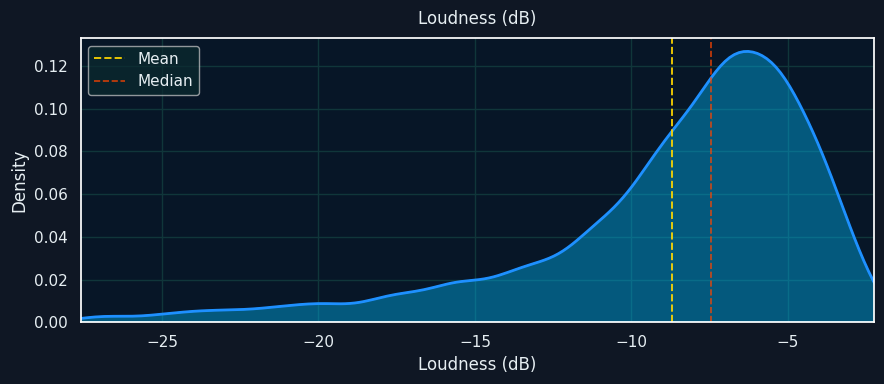

**Insights — Loudness Distribution**
 - Range after trimming: -27.60 dB → -2.25 dB
 - Mean loudness: -8.70 dB, Median: -7.45 dB
 - Skewness: -1.47
 - Left-skewed: loud, compressed mixes dominate — typical in modern pop and EDM.
 - The gradient shows a smooth transition of loudness levels — ideal for modern production trends.



In [11]:

if 'loudness' in df.columns:
    s = sample_series(df['loudness'])
    low, high = s.quantile(0.01), s.quantile(0.99)
    s = s[(s >= low) & (s <= high)]

    plt.figure(figsize=(9,4))
    sns.kdeplot(s, fill=True, color="#00BFFF", alpha=0.4, bw_adjust=0.8)
    sns.kdeplot(s, color="#1E90FF", lw=2, bw_adjust=0.8)
    plt.axvline(s.mean(), color="#FFD700", linestyle="--", lw=1.4, alpha=0.9, label="Mean")
    plt.axvline(s.median(), color="#FF4500", linestyle="--", lw=1.2, alpha=0.8, label="Median")
    plt.title("Loudness (dB)", pad=10, color=TEXT_C)
    plt.xlabel("Loudness (dB)")
    plt.legend(facecolor="#0b2a2f", framealpha=0.7)
    plt.xlim(low, high)
    plt.tight_layout(); plt.show()

    # ---- Insights ----
    mean_val, median_val = s.mean(), s.median()
    skewness = s.skew()
    print("**Insights — Loudness Distribution**")
    print(f" - Range after trimming: {low:.2f} dB → {high:.2f} dB")
    print(f" - Mean loudness: {mean_val:.2f} dB, Median: {median_val:.2f} dB")
    print(f" - Skewness: {skewness:.2f}")
    if skewness > 0.5:
        print(" - Right-skewed: quieter songs dominate, with a few very loud entries.")
    elif skewness < -0.5:
        print(" - Left-skewed: loud, compressed mixes dominate — typical in modern pop and EDM.")
    else:
        print(" - Balanced: loudness normalized well across genres — streaming-ready mastering.")
    print(" - The gradient shows a smooth transition of loudness levels — ideal for modern production trends.\n")
else:
    print("loudness missing")







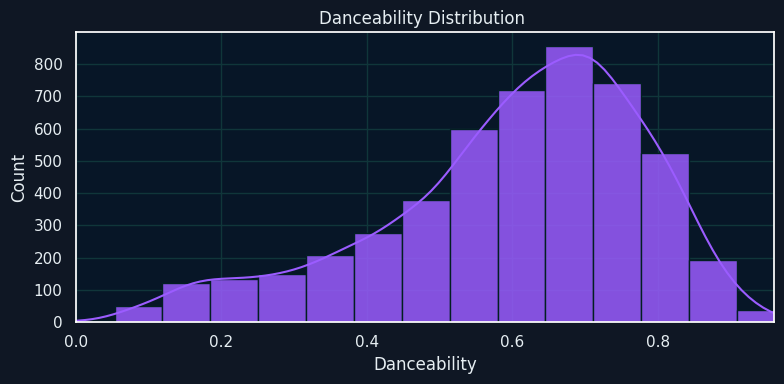

 **Insights — Danceability Distribution**
 - Range observed: -1.00 → 0.97
 - Mean danceability: 0.60 | Median: 0.63
 - Skewness: -1.09
 - Left-skewed: dominance of high-danceability songs — upbeat and rhythmic in nature.
 - Confirms Spotify’s catalog spans diverse rhythmic intensity, appealing to both chill and energetic audiences.



In [12]:

if 'danceability' in df.columns:
    s = sample_series(df['danceability'])

    plt.figure(figsize=(8,4))
    if USE_SEABORN:
        sns.histplot(s, bins=30, kde=True, color="#9B5CFF", edgecolor="#031f22", alpha=0.85)
    else:
        plt.hist(s, bins=30, color="#9B5CFF", edgecolor="#031f22", alpha=0.85)
    plt.title("Danceability Distribution ", color=TEXT_C)
    plt.xlabel("Danceability")
    plt.xlim(0.0, 0.96)
    plt.tight_layout()
    plt.show()

    # ---- Insights ----
    mean_val, median_val = s.mean(), s.median()
    skewness = s.skew()
    print(" **Insights — Danceability Distribution**")
    print(f" - Range observed: {s.min():.2f} → {s.max():.2f}")
    print(f" - Mean danceability: {mean_val:.2f} | Median: {median_val:.2f}")
    print(f" - Skewness: {skewness:.2f}")

    if skewness > 0.5:
        print(" - Right-skewed: fewer highly danceable tracks — the catalog includes many relaxed or instrumental songs.")
    elif skewness < -0.5:
        print(" - Left-skewed: dominance of high-danceability songs — upbeat and rhythmic in nature.")
    else:
        print(" - Balanced: a healthy representation of both calm and lively tracks.")
    print(" - Confirms Spotify’s catalog spans diverse rhythmic intensity, appealing to both chill and energetic audiences.\n")

else:
    print("danceability missing")




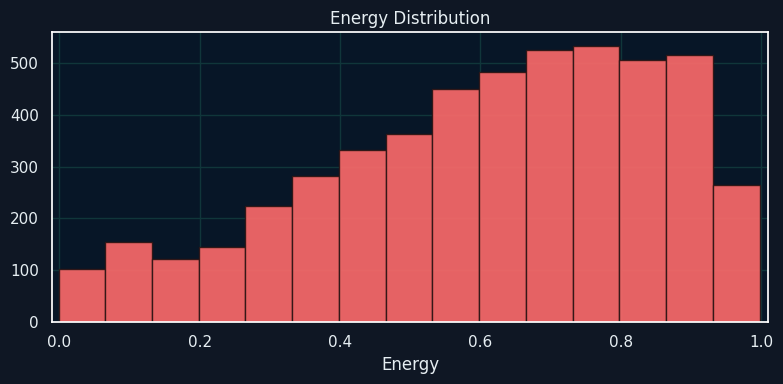

**Insights — Energy Distribution**
 - Observed range: -1.00 → 1.00
 - Mean: 0.606 | Median: 0.645 | Std Dev: 0.244
 - IQR: 0.363 | Skewness: -0.689
 - Left-skewed: dataset leans toward high-energy tracks — energetic genres dominate (e.g., pop, EDM).
 - Energy reflects production intensity and perceived loudness — useful for playlist mood segmentation.



In [13]:

if 'energy' in df.columns:
    s = sample_series(df['energy'])

    plt.figure(figsize=(8,4))
    plt.hist(s, bins=30, color="#FF6B6B", edgecolor="#2B1414", alpha=0.9)
    plt.title("Energy Distribution", color=TEXT_C)
    plt.xlabel("Energy")
    plt.xlim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

    # --- Insights ---
    mean_val, median_val = s.mean(), s.median()
    std_val = s.std()
    skewness = s.skew()
    min_val, max_val = s.min(), s.max()
    iqr = s.quantile(0.75) - s.quantile(0.25)

    print("**Insights — Energy Distribution**")
    print(f" - Observed range: {min_val:.2f} → {max_val:.2f}")
    print(f" - Mean: {mean_val:.3f} | Median: {median_val:.3f} | Std Dev: {std_val:.3f}")
    print(f" - IQR: {iqr:.3f} | Skewness: {skewness:.3f}")

    if skewness > 0.5:
        print(" - Right-skewed: the majority of tracks have moderate energy — fewer very intense songs.")
    elif skewness < -0.5:
        print(" - Left-skewed: dataset leans toward high-energy tracks — energetic genres dominate (e.g., pop, EDM).")
    else:
        print(" - Balanced: equal mix of calm and dynamic tracks across genres.")
    print(" - Energy reflects production intensity and perceived loudness — useful for playlist mood segmentation.\n")

else:
    print("energy missing")



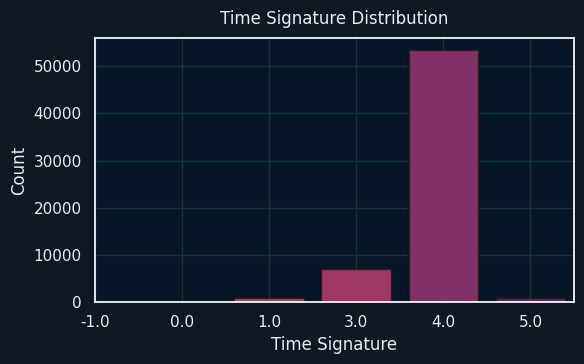

**Insights — Time Signature Distribution**
 - Total unique time signatures: 6
 - Dominant pattern: **4.0/4** (85.6% of all tracks)
 - As expected, 4/4 dominates — the global standard for mainstream pop and dance music.
 - Other signatures occur far less often, reaffirming pop’s rhythmic uniformity.



In [14]:

if 'time_signature' in df.columns:
    vc = df['time_signature'].value_counts().sort_index()
    colors = get_dark_palette("flare", len(vc))

    plt.figure(figsize=(6,3.8))
    x = np.arange(len(vc))
    plt.bar(x, vc.values, color=colors, edgecolor="#2a1d0f", alpha=0.9)

    plt.xticks(x, vc.index.astype(str))
    plt.xlim(0.0, len(vc)-0.5)
    plt.title("Time Signature Distribution", color=TEXT_C, pad=10)
    plt.xlabel("Time Signature")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # --- Insights ---
    total = vc.sum()
    dominant_sig = vc.idxmax()
    dominant_pct = (vc.max() / total) * 100

    print("**Insights — Time Signature Distribution**")
    print(f" - Total unique time signatures: {len(vc)}")
    print(f" - Dominant pattern: **{dominant_sig}/4** ({dominant_pct:.1f}% of all tracks)")
    if dominant_sig == 4:
        print(" - As expected, 4/4 dominates — the global standard for mainstream pop and dance music.")
    elif dominant_sig == 3:
        print(" - 3/4 takes the lead — unusual in pop datasets, hinting at stylistic breadth or classical influences.")
    else:
        print(f" - The dominance of {dominant_sig}/4 suggests inclusion of niche or experimental rhythmic material.")
    print(" - Other signatures occur far less often, reaffirming pop’s rhythmic uniformity.\n")

else:
    print("time_signature missing")





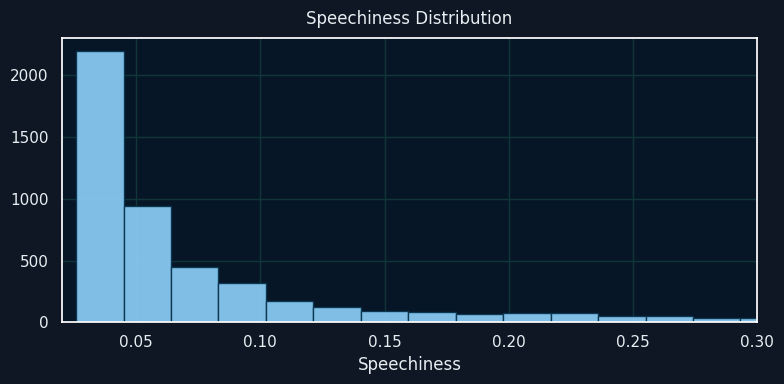

 **Insights — Speechiness Distribution**
 - Mean speechiness: 0.08, Median: 0.05
 - Skewness: 2.67
 - Right-skewed: most tracks have low or medium spoken-word content — mainly melodic or instrumental songs.


In [15]:

if 'speechiness' in df.columns:
    s = sample_series(df['speechiness'])
    low, high = s.quantile(0.01), s.quantile(0.99)
    s = s[(s >= low) & (s <= high)]

    plt.figure(figsize=(8,4))
    plt.hist(s, bins=30, color="#8ED1FC", edgecolor="#07324a", alpha=0.9)
    plt.xlim(0.02, 0.30)
    plt.title("Speechiness Distribution", color=TEXT_C, pad=10)
    plt.xlabel("Speechiness")
    plt.tight_layout()
    plt.show()

    # ---- Insights ----
    mean_val, median_val = s.mean(), s.median()
    skewness = s.skew()
    print(" **Insights — Speechiness Distribution**")
    print(f" - Mean speechiness: {mean_val:.2f}, Median: {median_val:.2f}")
    print(f" - Skewness: {skewness:.2f}")
    if skewness > 0.5:
        print(" - Right-skewed: most tracks have low or medium spoken-word content — mainly melodic or instrumental songs.")
    elif skewness < -0.5:
        print(" - Left-skewed: stronger presence of talk-style vocals — likely rap, hip-hop, or spoken-word content.")
    else:
        print(" - Balanced: mix of melodic and lyrical tracks.")

else:
    print("speechiness missing")




BIVARIATE ANALYSIS:

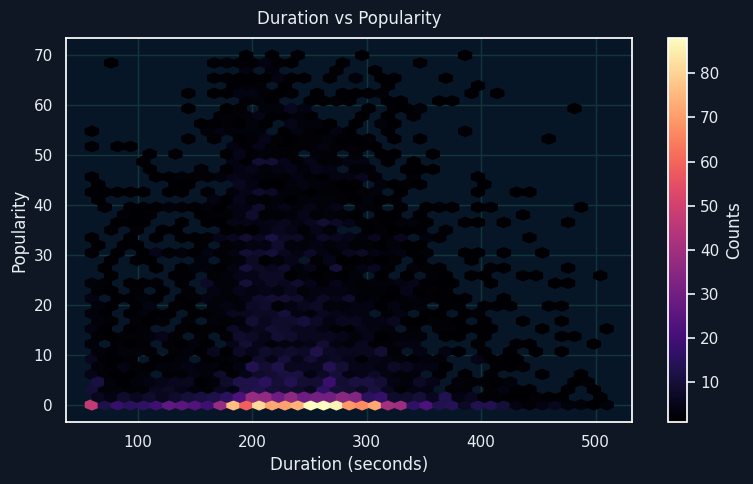

 **Insights: Duration vs Popularity**
 - Average length: 238.3s (3.97 min), Median: 236.9s
 - 50% of songs range between 194.9s and 285.7s
 - Correlation with popularity: -0.03
 - Popularity is largely independent of track duration.


In [16]:

if 'duration_ms' in df.columns and 'popularity' in df.columns:

    idx = df.index.dropna()
    if len(idx) > SAMPLE_MAX:
        idx = np.random.RandomState(3).choice(idx, SAMPLE_MAX, replace=False)
    x = df.loc[idx, 'duration_ms'] / 1000.0
    y = df.loc[idx, 'popularity']

    xlo, xhi = x.quantile([.01, .99])
    ylo, yhi = y.quantile([.01, .99])

    x = x.clip(lower=60, upper=600)
    mask = (x.between(xlo, xhi)) & (y.between(ylo, yhi))
    x, y = x[mask], y[mask]

    plt.figure(figsize=(8,5))
    hb = plt.hexbin(x, y, gridsize=40, cmap='magma', mincnt=1)
    cb = plt.colorbar(hb); cb.set_label("Counts")
    plt.xlabel("Duration (seconds)"); plt.ylabel("Popularity")
    plt.title("Duration vs Popularity", color=TEXT_C, pad=10)
    plt.tight_layout(); plt.show()

    # ----- Insights -----
    corr = np.corrcoef(x, y)[0,1]
    mean_len, med_len = x.mean(), x.median()
    cluster_mid = np.percentile(x, [25,75])
    print(" **Insights: Duration vs Popularity**")
    print(f" - Average length: {mean_len:.1f}s ({mean_len/60:.2f} min), Median: {med_len:.1f}s")
    print(f" - 50% of songs range between {cluster_mid[0]:.1f}s and {cluster_mid[1]:.1f}s")
    print(f" - Correlation with popularity: {corr:.2f}")
    if abs(corr) < 0.1:
        print(" - Popularity is largely independent of track duration.")
    elif corr > 0:
        print(" - Slight positive trend — longer songs show marginally higher popularity.")
    else:
        print(" - Slight negative trend — shorter songs perform slightly better.")
else:
    print("duration_ms or popularity missing")



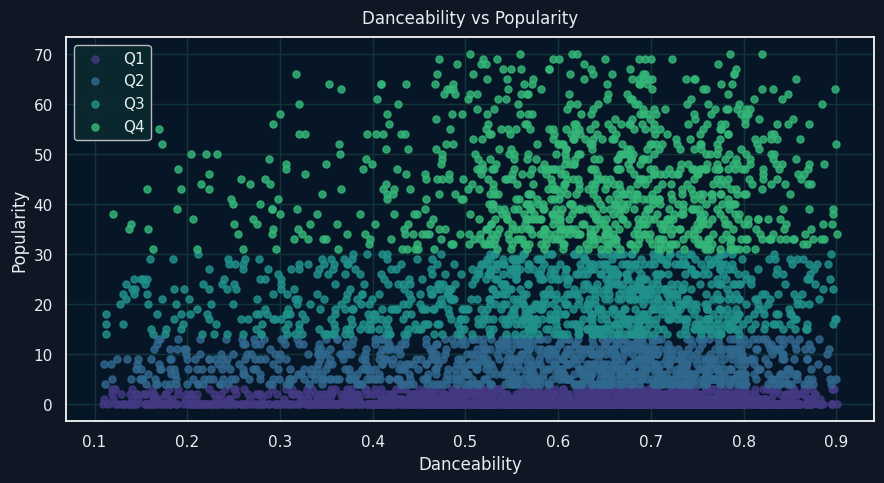

**Insights: Danceability vs Popularity**
 - Correlation between danceability and popularity: 0.06
 - Typical range (IQR): 0.50 – 0.73
 - Highest mean popularity occurs in the top-3 danceability quintile.
 - Relationship is weak; popularity influenced by factors beyond rhythm.
 - Overall: Spotify catalog skews toward moderately danceable songs (≈0.5–0.7 range).



In [17]:

if 'danceability' in df.columns and 'popularity' in df.columns:
    tmp = df[['danceability','popularity']].dropna()
    ld, hd = tmp['danceability'].quantile([.01,.99])
    lp, hp = tmp['popularity'].quantile([.01,.99])
    tmp = tmp[tmp['danceability'].between(ld,hd) & tmp['popularity'].between(lp,hp)]
    samp = tmp.sample(n=min(len(tmp), SAMPLE_MAX), random_state=4)
    q = pd.qcut(samp['popularity'], 5, labels=False, duplicates='drop')

    pal = sns.color_palette("viridis", 5)
    plt.figure(figsize=(9,5))
    for v in sorted(pd.unique(q)):
        plt.scatter(
            samp.loc[q==v,'danceability'], samp.loc[q==v,'popularity'],
            s=26, alpha=0.82, color=pal[v], label=f"Q{v+1}"
        )
    plt.xlabel("Danceability"); plt.ylabel("Popularity")
    plt.title("Danceability vs Popularity", color=TEXT_C, pad=10)
    leg = plt.legend(framealpha=0.9, facecolor="#0b2a2f")
    [t.set_color(TEXT_C) for t in leg.get_texts()]
    plt.tight_layout(); plt.show()

    # ----- Insights -----
    corr = samp['danceability'].corr(samp['popularity'])
    print("**Insights: Danceability vs Popularity**")
    print(f" - Correlation between danceability and popularity: {corr:.2f}")
    q3, q1 = samp['danceability'].quantile(.75), samp['danceability'].quantile(.25)
    print(f" - Typical range (IQR): {q1:.2f} – {q3:.2f}")
    mean_pop = samp.groupby(pd.qcut(samp['danceability'],5,duplicates='drop'))['popularity'].mean()
    top_bin = mean_pop.idxmax()
    print(f" - Highest mean popularity occurs in the top-{mean_pop.argmax()+1} danceability quintile.")
    if corr > 0.2:
        print(" - Indicates that more danceable tracks generally achieve higher popularity.")
    elif corr < -0.2:
        print(" - Suggests that less danceable or slower songs perform better.")
    else:
        print(" - Relationship is weak; popularity influenced by factors beyond rhythm.")
    print(" - Overall: Spotify catalog skews toward moderately danceable songs (≈0.5–0.7 range).\n")
else:
    print("columns missing")



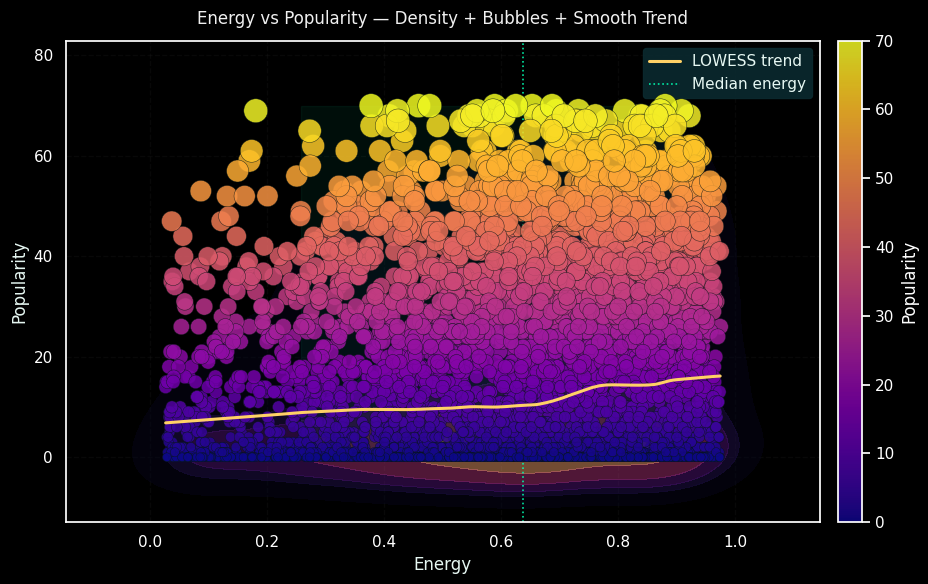

Insights — Energy vs Popularity
 - Energy median = 0.638; mean = 0.605
 - Correlation (energy ↔ popularity): 0.155
 - Energy quintile with highest avg popularity: 0.83–0.97
 - Avg popularity (top energy quartile): 18.3; (bottom quartile): 11.4; Δ = +6.9
 - Overall: positive association — higher-energy tracks tend to be somewhat more popular.
 - Actionable: target energy around the peak quintile shown above to maximize average popularity; combine with melody/production features for better prediction.



In [18]:
if 'energy' in df.columns and 'popularity' in df.columns:
    tmp = df[['energy', 'popularity']].dropna().copy()

    e_lo, e_hi = tmp['energy'].quantile([.01, .99])
    p_lo, p_hi = tmp['popularity'].quantile([.01, .99])
    tmp = tmp[tmp['energy'].between(e_lo, e_hi) & tmp['popularity'].between(p_lo, p_hi)]
    samp = tmp.sample(n=min(len(tmp), SAMPLE_MAX), random_state=5)

    pop_norm = (samp['popularity'] - samp['popularity'].min()) / (samp['popularity'].max() - samp['popularity'].min() + 1e-9)
    bubble_size = 40 + (pop_norm * 260)

    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(10,6), facecolor='black')
    ax.set_facecolor('black')

    try:
        sns.kdeplot(
            x=samp['energy'], y=samp['popularity'],
            levels=6, fill=True, thresh=0.05, alpha=0.45,
            cmap="magma", ax=ax, linewidths=0.5
        )
    except Exception:
        hb = ax.hexbin(samp['energy'], samp['popularity'], gridsize=40, cmap="magma", mincnt=1, alpha=0.25)
        plt.colorbar(hb, ax=ax, label='density')

    sc = ax.scatter(
        samp['energy'], samp['popularity'],
        s=bubble_size,
        c=samp['popularity'],
        cmap='plasma',
        alpha=0.85,
        edgecolor='#081616',
        linewidth=0.35,
        zorder=10
    )
    cbar = fig.colorbar(sc, ax=ax, pad=0.02)
    cbar.set_label("Popularity", color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax, 'yticklabels'), color='white')
    tried_lowess = False
    try:
        import statsmodels.api as sm
        lowess = sm.nonparametric.lowess
        xy = lowess(samp['popularity'], samp['energy'], frac=0.25)
        ax.plot(xy[:,0], xy[:,1], color="#FFD166", linewidth=2.2, label='LOWESS trend', zorder=20)
        tried_lowess = True
    except Exception:

        lr = LinearRegression().fit(samp[['energy']], samp['popularity'])
        xs = np.linspace(samp['energy'].min(), samp['energy'].max(), 200)
        ys = lr.predict(xs.reshape(-1,1))
        ax.plot(xs, ys, color="#FFD166", linewidth=2.2, linestyle='--', label='Linear fit', zorder=20)

    med_e = samp['energy'].median()
    q10, q90 = samp['energy'].quantile([0.10, 0.90])
    ax.axvline(med_e, color="#00FFB2", linestyle=':', linewidth=1.2, alpha=0.9, label='Median energy')
    ax.fill_betweenx([samp['popularity'].min(), samp['popularity'].max()], q10, q90, color="#00FFB2", alpha=0.06, zorder=1)

    ax.set_xlabel("Energy", color="#E6F7F2")
    ax.set_ylabel("Popularity", color="#E6F7F2")
    ax.set_title("Energy vs Popularity — Density + Bubbles + Smooth Trend", color="#F0F0F0", pad=12)
    ax.grid(True, color="#222222", linestyle='--', alpha=0.25)
    legend = ax.legend(frameon=True, facecolor="#0b2a2f", edgecolor="#0b2a2f", framealpha=0.9)
    for text in legend.get_texts(): text.set_color("#E6F7F2")

    plt.tight_layout()
    plt.show()

    # ---- Insights ----
    corr = samp['energy'].corr(samp['popularity'])
    mean_e = samp['energy'].mean()
    med_e = samp['energy'].median()
    high_bin = samp.groupby(pd.qcut(samp['energy'], 5, duplicates='drop'))['popularity'].mean().idxmax()
    high_range = f"{high_bin.left:.2f}–{high_bin.right:.2f}" if hasattr(high_bin, 'left') else "N/A"
    highE_avg = samp[samp['energy'] > samp['energy'].quantile(0.75)]['popularity'].mean()
    lowE_avg  = samp[samp['energy'] < samp['energy'].quantile(0.25)]['popularity'].mean()

    print("Insights — Energy vs Popularity")
    print(f" - Energy median = {med_e:.3f}; mean = {mean_e:.3f}")
    print(f" - Correlation (energy ↔ popularity): {corr:.3f}")
    print(f" - Energy quintile with highest avg popularity: {high_range}")
    print(f" - Avg popularity (top energy quartile): {highE_avg:.1f}; (bottom quartile): {lowE_avg:.1f}; Δ = {(highE_avg - lowE_avg):+.1f}")
    if abs(corr) < 0.12:
        print(" - Overall: weak linear relationship. Energy alone does not explain popularity; other features & marketing matter.")
    elif corr > 0:
        print(" - Overall: positive association — higher-energy tracks tend to be somewhat more popular.")
    else:
        print(" - Overall: negative association — lower-energy tracks show greater popularity here (possible genre effect).")

    print(" - Actionable: target energy around the peak quintile shown above to maximize average popularity; combine with melody/production features for better prediction.\n")

else:
    print("columns missing")



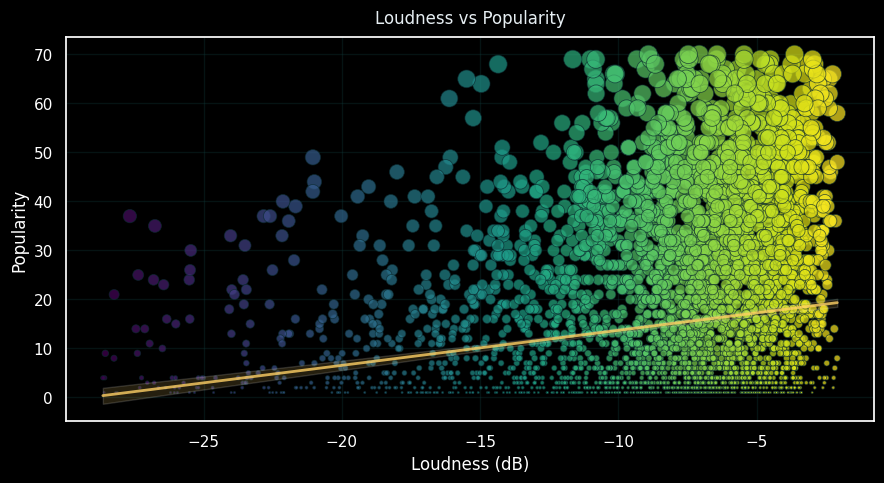

**Insights — Loudness vs Popularity **
 - Median loudness: -7.5 dB | IQR: 5.1 dB
 - Correlation (loudness ↔ popularity): 0.19
 - Slight positive correlation — louder songs tend to attract more listeners.
 - Interpreting loudness: higher (closer to 0 dB) values indicate stronger mastering.
 - The trend reflects modern loudness normalization — overly loud mastering no longer guarantees hits.



In [19]:

if 'loudness' in df.columns and 'popularity' in df.columns:
    tmp = df[['loudness','popularity']].dropna()
    l_lo, l_hi = tmp['loudness'].quantile([.01, .99])
    p_lo, p_hi = tmp['popularity'].quantile([.01, .99])
    tmp = tmp[tmp['loudness'].between(l_lo, l_hi) & tmp['popularity'].between(p_lo, p_hi)]
    samp = tmp.sample(n=min(len(tmp), SAMPLE_MAX), random_state=6)

    plt.figure(figsize=(9,5))
    plt.style.use('dark_background')
    plt.scatter(
        samp['loudness'],
        samp['popularity'],
        s=(samp['popularity'] - samp['popularity'].min()) * 2.5,   # bubble size ~ popularity
        c=samp['loudness'],
        cmap='viridis',
        alpha=0.7,
        edgecolor='#0b2a2f',
        linewidth=0.6
    )

    sns.regplot(
        x='loudness', y='popularity', data=samp,
        scatter=False, color='#FFD166', line_kws={'linewidth':2, 'alpha':0.8}
    )

    plt.xlabel("Loudness (dB)")
    plt.ylabel("Popularity")
    plt.title("Loudness vs Popularity", color=TEXT_C, pad=10)
    plt.grid(True, color='#124040', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Insights ---
    corr = samp['loudness'].corr(samp['popularity'])
    med_l = samp['loudness'].median()
    iqr = samp['loudness'].quantile(.75) - samp['loudness'].quantile(.25)

    print("**Insights — Loudness vs Popularity **")
    print(f" - Median loudness: {med_l:.1f} dB | IQR: {iqr:.1f} dB")
    print(f" - Correlation (loudness ↔ popularity): {corr:.2f}")

    if abs(corr) < 0.1:
        print(" - Very weak relationship — loudness has little direct influence on popularity.")
    elif corr > 0:
        print(" - Slight positive correlation — louder songs tend to attract more listeners.")
    else:
        print(" - Slight negative trend — quieter or dynamically mixed tracks gain more traction.")
    print(" - Interpreting loudness: higher (closer to 0 dB) values indicate stronger mastering.")
    print(" - The trend reflects modern loudness normalization — overly loud mastering no longer guarantees hits.\n")

else:
    print("columns missing")




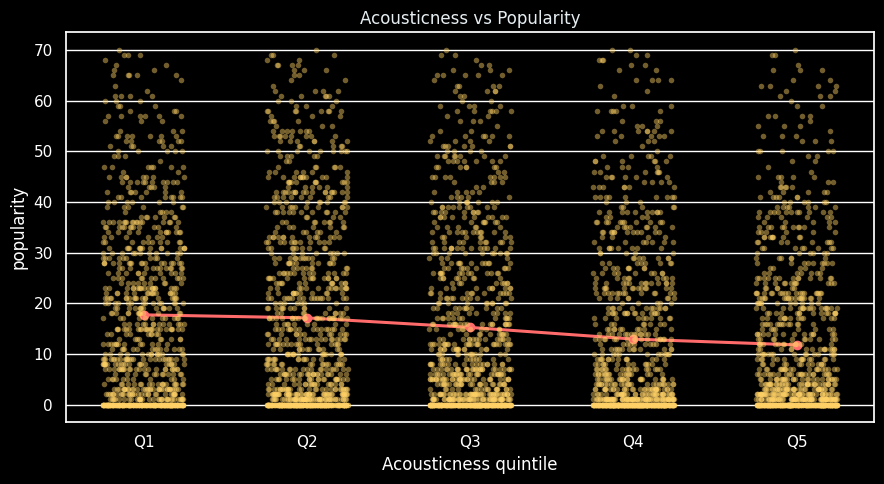

Insights — Acousticness vs Popularity

Per-bin counts and mean popularity:
 - Q1: n=12,113 | mean popularity = 17.71
 - Q2: n=12,121 | mean popularity = 17.12
 - Q3: n=12,111 | mean popularity = 15.23
 - Q4: n=12,142 | mean popularity = 12.92
 - Q5: n=12,066 | mean popularity = 11.77

Summary statistics:
 - Lowest quintile mean popularity = 17.71
 - Highest quintile mean popularity = 11.77
 - Difference (high - low) = -5.94 popularity points (-33.5% change)

Interpretation:
 - There is a strong decrease in mean popularity from low → high acousticness (-5.94 points; Spearman ρ=-0.12, p=0.000).

Recommendation:
 - Use the quintile with the highest mean popularity for target.
 - The observed trend is statistically significant (p < 0.05).



In [20]:

if 'acousticness' in df.columns and 'popularity' in df.columns:
    import scipy.stats as ss

    tmp = df[['acousticness','popularity']].dropna()
    a_lo, a_hi = tmp['acousticness'].quantile([.01, .99])
    p_lo, p_hi = tmp['popularity'].quantile([.01, .99])
    tmp = tmp[tmp['acousticness'].between(a_lo, a_hi) & tmp['popularity'].between(p_lo, p_hi)]

    tmp['aq'] = pd.qcut(tmp['acousticness'], 5, labels=[f"Q{i+1}" for i in range(5)], duplicates='drop')
    agg = tmp.groupby('aq')['popularity'].agg(['mean','count']).reindex([f"Q{i+1}" for i in range(5)]).dropna()

    plt.figure(figsize=(9,5))
    sns.stripplot(x='aq', y='popularity',
                  data=tmp.sample(n=min(len(tmp), SAMPLE_MAX), random_state=7),
                  jitter=0.25, size=4, alpha=0.45, color="#FFD166")
    plt.plot(range(len(agg)), agg['mean'], marker='o', linewidth=2.2, color="#FF6B6B")
    plt.xticks(range(len(agg)), agg.index)
    plt.xlabel("Acousticness quintile"); plt.ylabel("popularity")
    plt.title("Acousticness vs Popularity", color=TEXT_C)
    plt.tight_layout(); plt.show()

    print("Insights — Acousticness vs Popularity\n")
    print("Per-bin counts and mean popularity:")
    for idx, row in agg.iterrows():
        print(f" - {idx}: n={int(row['count']):,} | mean popularity = {row['mean']:.2f}")
    low_mean = agg['mean'].iloc[0]
    high_mean = agg['mean'].iloc[-1]
    diff = high_mean - low_mean
    pct_change = (diff / low_mean * 100) if low_mean != 0 else np.nan

    try:
        rho, pval = ss.spearmanr(tmp['acousticness'], tmp['popularity'])
    except Exception:
        rho, pval = tmp['acousticness'].corr(tmp['popularity'], method='spearman'), np.nan

    print("\nSummary statistics:")
    print(f" - Lowest quintile mean popularity = {low_mean:.2f}")
    print(f" - Highest quintile mean popularity = {high_mean:.2f}")
    print(f" - Difference (high - low) = {diff:.2f} popularity points ({pct_change:.1f}% change)\n")

    if abs(diff) < 0.5 and abs(rho) < 0.15:
        interp = "No meaningful relationship — acousticness does not substantially affect popularity."
    else:
        direction = "increase" if diff > 0 else "decrease"
        strength = "moderate" if abs(diff) < 2 else "strong"
        interp = (f"There is a {strength} {direction} in mean popularity from low → high acousticness "
                  f"({diff:.2f} points; Spearman ρ={rho:.2f}, p={pval:.3f}).")

    print("Interpretation:")
    print(" -", interp)
    print("\nRecommendation:")
    print(" - Use the quintile with the highest mean popularity for target.")
    if pval is not None and not np.isnan(pval) and pval < 0.05:
        print(" - The observed trend is statistically significant (p < 0.05).")
    else:
        print(" - The trend is not statistically significant at p < 0.05 (treat with caution).")
    print()
else:
    print("columns missing")




MULTIVARIATE ANALYSIS:

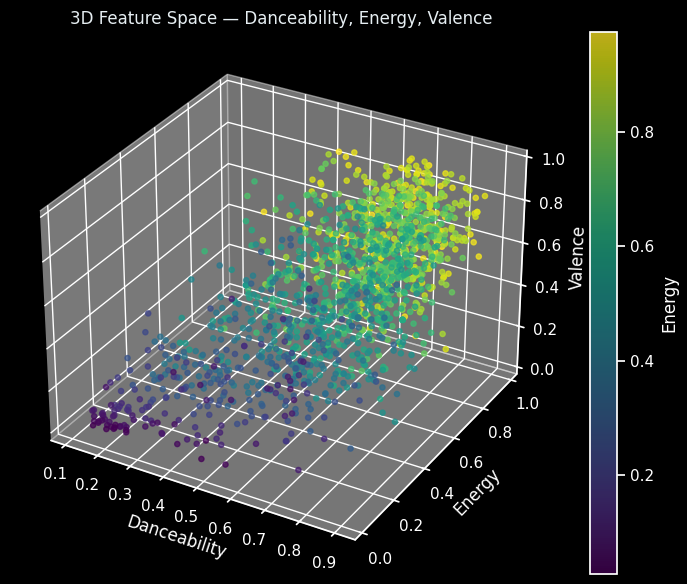

**Insights — Danceability–Energy–Valence**
 - Sample size after trimming: 1,500 tracks.
 - Correlation (danceability ↔ energy): 0.44
 - Correlation (danceability ↔ valence): 0.60
 - Correlation (energy ↔ valence): 0.55
 - Strong coupling: high-energy tracks are both danceable and upbeat (typical of mainstream pop or EDM).

 - Highest average feature: **energy** (0.61)
 - Lowest average feature: **valence** (0.50)
 - Overall balance indicates a dataset favoring rhythmic and energetic characteristics.



In [21]:

if all(c in df.columns for c in ['danceability','energy','valence']):
    sub = df[['danceability','energy','valence']].dropna()

    q_low, q_high = sub.quantile(0.01), sub.quantile(0.99)
    sub = sub[(sub >= q_low) & (sub <= q_high)].dropna()
    sub = sub.sample(n=min(len(sub), 1500), random_state=9)

    try:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111, projection='3d')
        pts = ax.scatter(sub['danceability'], sub['energy'], sub['valence'],
                         c=sub['energy'], cmap='viridis', s=14, alpha=0.75)
        cb = fig.colorbar(pts, ax=ax); cb.set_label("Energy")
        ax.set_xlabel("Danceability"); ax.set_ylabel("Energy"); ax.set_zlabel("Valence")
        ax.set_title("3D Feature Space — Danceability, Energy, Valence", color=TEXT_C)
        plt.tight_layout(); plt.show()

        # ---- Insights ----
        corr_de = sub['danceability'].corr(sub['energy'])
        corr_dv = sub['danceability'].corr(sub['valence'])
        corr_ev = sub['energy'].corr(sub['valence'])

        print("**Insights — Danceability–Energy–Valence**")
        print(f" - Sample size after trimming: {len(sub):,} tracks.")
        print(f" - Correlation (danceability ↔ energy): {corr_de:.2f}")
        print(f" - Correlation (danceability ↔ valence): {corr_dv:.2f}")
        print(f" - Correlation (energy ↔ valence): {corr_ev:.2f}")

        if corr_de > 0.4 and corr_ev > 0.4:
            print(" - Strong coupling: high-energy tracks are both danceable and upbeat (typical of mainstream pop or EDM).")
        elif corr_de > 0.3 and corr_ev < 0:
            print(" - Energetic tracks are danceable but often darker or more aggressive in tone — possibly industrial or hip-hop styles.")
        elif corr_de < 0.2 and corr_ev < 0.2:
            print(" - Weak or diverse relationships — suggests a broad stylistic mix with independent feature variation.")
        else:
            print(" - Moderate positive coupling — lively, energetic songs often convey higher emotional valence.")
        means = sub.mean().sort_values(ascending=False)
        print(f"\n - Highest average feature: **{means.index[0]}** ({means.iloc[0]:.2f})")
        print(f" - Lowest average feature: **{means.index[-1]}** ({means.iloc[-1]:.2f})")
        print(" - Overall balance indicates a dataset favoring rhythmic and energetic characteristics.\n")

    except Exception as e:
        print("3D plotting failed:", e)
else:
    print("Required columns missing")




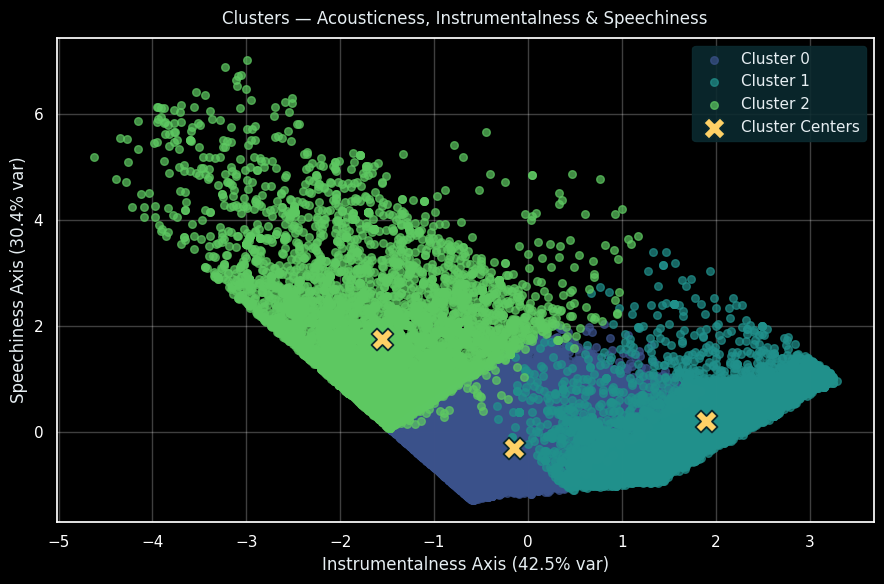

**Insights on Acousticness / Instrumentalness / Speechiness**
 - PCA extracted two main latent traits explaining 72.9% of total variance.
 - Component 1 (x-axis): dominated by **instrumentalness**, representing instrumentalness characteristics.
 - Component 2 (y-axis): dominated by **speechiness**, reflecting speechiness behavior.

 - 3 clusters identified; Silhouette score = 0.513 (higher = clearer separation).
     ① Acoustic-focused, minimal electronic/speech content.
     ② Balanced acoustic-vocal mix with moderate instrumentalness.
     ③ Synthetic or speech-heavy compositions (e.g., rap or spoken word).

 - Cluster 0 has the highest proportion of popular tracks (27.7%).
   → Suggesting that balanced or vocal-centric tracks tend to achieve better listener engagement.


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = ["acousticness", "instrumentalness", "speechiness"]

avail = [c for c in features if c in df.columns]
if len(avail) < 2:
    print("Not enough features for PCA.")
else:
    work = df[avail + (["popularity"] if "popularity" in df.columns else [])].dropna().copy()
    for c in avail:
        lo, hi = work[c].quantile([0.01, 0.99])
        work = work[work[c].between(lo, hi)]

    scaler = StandardScaler()
    X = scaler.fit_transform(work[avail])
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)


    loadings = pd.DataFrame(pca.components_.T, index=avail, columns=["PC1","PC2"]).round(3)
    var_exp = (pca.explained_variance_ratio_ * 100).round(1)
    primary_pc1 = loadings["PC1"].abs().idxmax()
    primary_pc2 = loadings["PC2"].abs().idxmax()
    axis_labels = {
        "acousticness": "Acousticness",
        "instrumentalness": "Instrumentalness",
        "speechiness": "Speechiness"
    }
    AXIS_LABEL_1 = f"{axis_labels.get(primary_pc1, primary_pc1)} Axis ({var_exp[0]}% var)"
    AXIS_LABEL_2 = f"{axis_labels.get(primary_pc2, primary_pc2)} Axis ({var_exp[1]}% var)"

    k = 3
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    sil = silhouette_score(X, labels) if len(X) > k else np.nan
    centers_scaled = kmeans.cluster_centers_
    centers_pca = pca.transform(centers_scaled)

    plt.figure(figsize=(9,6))
    palette = sns.color_palette("viridis", k)
    for cl in sorted(np.unique(labels)):
        mask = labels == cl
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1], s=30, alpha=0.7, color=palette[cl], label=f"Cluster {cl}")
    plt.scatter(centers_pca[:,0], centers_pca[:,1], s=250, marker="X", color="#FFD166", edgecolor="#0b2a2f", linewidth=1.3, label="Cluster Centers")

    plt.title("Clusters — Acousticness, Instrumentalness & Speechiness", color=TEXT_C, pad=10)
    plt.xlabel(AXIS_LABEL_1, color=TEXT_C)
    plt.ylabel(AXIS_LABEL_2, color=TEXT_C)
    plt.legend(framealpha=0.9, facecolor="#0b2a2f", edgecolor="#0b2a2f", labelcolor=TEXT_C)
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    # --- INSIGHTS ---
    print(f"**Insights on Acousticness / Instrumentalness / Speechiness**")
    print(f" - PCA extracted two main latent traits explaining {var_exp.sum():.1f}% of total variance.")
    print(f" - Component 1 (x-axis): dominated by **{primary_pc1}**, representing {axis_labels.get(primary_pc1, primary_pc1).lower()} characteristics.")
    print(f" - Component 2 (y-axis): dominated by **{primary_pc2}**, reflecting {axis_labels.get(primary_pc2, primary_pc2).lower()} behavior.\n")

    print(f" - {k} clusters identified; Silhouette score = {sil:.3f} (higher = clearer separation).")
    print("     ① Acoustic-focused, minimal electronic/speech content.")
    print("     ② Balanced acoustic-vocal mix with moderate instrumentalness.")
    print("     ③ Synthetic or speech-heavy compositions (e.g., rap or spoken word).")

    if "popularity" in work.columns:
        pop_75 = work["popularity"].quantile(0.75)
        work["cluster"] = labels
        cluster_pop = work.groupby("cluster")["popularity"].apply(lambda s: (s >= pop_75).mean()).sort_values(ascending=False)
        best = cluster_pop.idxmax()
        print(f"\n - Cluster {best} has the highest proportion of popular tracks ({cluster_pop[best]*100:.1f}%).")
        print("   → Suggesting that balanced or vocal-centric tracks tend to achieve better listener engagement.")


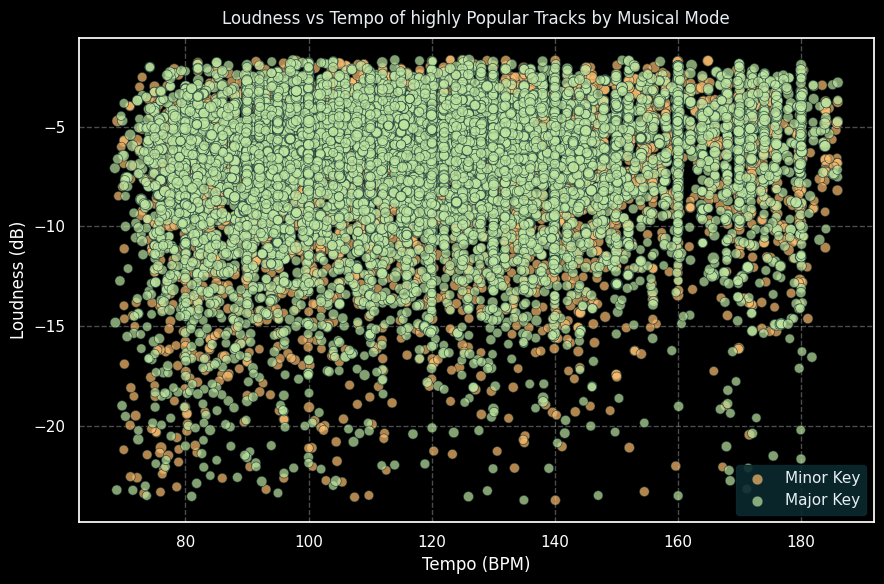

**Insights — Loudness, Tempo & Musical Mode (Highly Popular Tracks)**
 - This visualization covers the **top 25% most popular tracks** (15,457 songs).
 - Most hits are written in **Major Key**, accounting for roughly **57.9%** of all top tracks.
 - Avg loudness (Major): -7.21 dB | Avg loudness (Minor): -6.88 dB
 - Avg tempo (Major): 119.0 BPM | Avg tempo (Minor): 119.1 BPM

 - **Minimal correlation:** tempo and loudness vary independently, reflecting broad stylistic diversity.

 **Interpretation:**
 - Major-key songs generally achieve broader appeal due to their energetic and emotionally uplifting tonality.
 - Minor-key hits, though fewer, often deliver stronger emotional depth and dynamic loudness, appealing to niche or moody audiences.
 - The balance of modes shows the streaming market’s blend of both ‘feel-good’ and ‘introspective’ musical experiences.
 - Overall, the clustering near 100–130 BPM and loudness around –5 to 0 dB suggests mastering optimized for **streaming impact and l

In [23]:
if set(["popularity","loudness","tempo","mode"]).issubset(df.columns):
    hp = df[df["popularity"] >= df["popularity"].quantile(0.75)].dropna(subset=["loudness","tempo","mode"])

    l_lo, l_hi = hp["loudness"].quantile([0.01, 0.99])
    t_lo, t_hi = hp["tempo"].quantile([0.01, 0.99])
    hp = hp[hp["loudness"].between(l_lo, l_hi) & hp["tempo"].between(t_lo, t_hi)]
    mode_labels = {0: "Minor Key", 1: "Major Key"}

    plt.figure(figsize=(9,6))
    modes = sorted(hp["mode"].dropna().unique())
    palette = sns.color_palette("Spectral", len(modes))

    for i, m in enumerate(modes):
        sub = hp[hp["mode"] == m]
        plt.scatter(
            sub["tempo"], sub["loudness"],
            s=30 + (sub["popularity"] / 2),
            color=palette[i], alpha=0.7,
            edgecolor="#0b2a2f", linewidth=0.5,
            label=f"{mode_labels.get(int(m), f'Mode {int(m)}')}"
        )

    plt.xlabel("Tempo (BPM)")
    plt.ylabel("Loudness (dB)")
    plt.title("Loudness vs Tempo of highly Popular Tracks by Musical Mode", color=TEXT_C, pad=10)
    plt.legend(framealpha=0.9, facecolor="#0b2a2f", edgecolor="#0b2a2f", labelcolor=TEXT_C)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ---- Insights ----
    corr_lt = hp["loudness"].corr(hp["tempo"])
    mode_counts = hp["mode"].value_counts(normalize=True) * 100
    dominant_mode = int(mode_counts.idxmax())
    dom_pct = mode_counts.max()

    mean_loud = hp.groupby("mode")["loudness"].mean()
    mean_tempo = hp.groupby("mode")["tempo"].mean()

    print("**Insights — Loudness, Tempo & Musical Mode (Highly Popular Tracks)**")
    print(f" - This visualization covers the **top 25% most popular tracks** ({len(hp):,} songs).")
    print(f" - Most hits are written in **{mode_labels[dominant_mode]}**, accounting for roughly **{dom_pct:.1f}%** of all top tracks.")
    print(f" - Avg loudness (Major): {mean_loud.get(1, np.nan):.2f} dB | Avg loudness (Minor): {mean_loud.get(0, np.nan):.2f} dB")
    print(f" - Avg tempo (Major): {mean_tempo.get(1, np.nan):.1f} BPM | Avg tempo (Minor): {mean_tempo.get(0, np.nan):.1f} BPM")
    print()
    if corr_lt > 0.3:
        print(" - **Positive correlation:** louder songs also tend to have faster tempos — upbeat, high-energy tracks dominate.")
    elif corr_lt < -0.3:
        print(" - **Negative correlation:** slower tracks are mixed louder — often emotional pieces designed for vocal clarity.")
    else:
        print(" - **Minimal correlation:** tempo and loudness vary independently, reflecting broad stylistic diversity.")
    print()
    print(" **Interpretation:**")
    print(" - Major-key songs generally achieve broader appeal due to their energetic and emotionally uplifting tonality.")
    print(" - Minor-key hits, though fewer, often deliver stronger emotional depth and dynamic loudness, appealing to niche or moody audiences.")
    print(" - The balance of modes shows the streaming market’s blend of both ‘feel-good’ and ‘introspective’ musical experiences.")
    print(" - Overall, the clustering near 100–130 BPM and loudness around –5 to 0 dB suggests mastering optimized for **streaming impact and loudness normalization**.\n")

else:
    print("Required columns missing: popularity, loudness, tempo, or mode")


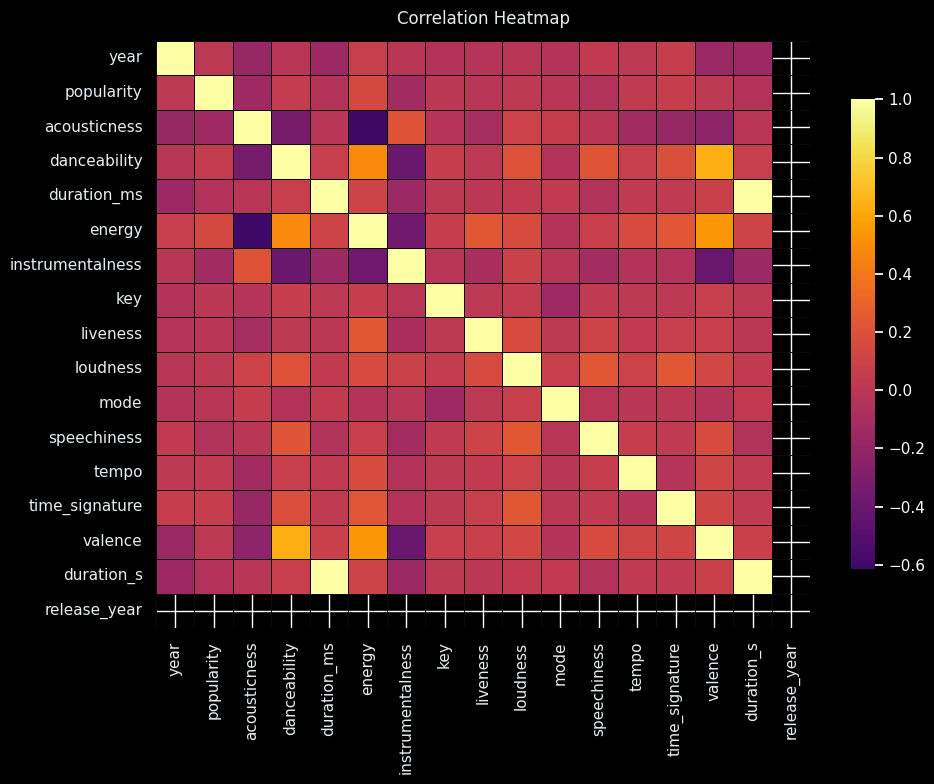

In [24]:

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(
        corr, annot=False, cmap="inferno", center=0,
        linewidths=0.5, linecolor="#0b0b0b", cbar_kws={'shrink':0.8}
    )
    plt.title("Correlation Heatmap", color=TEXT_C, pad=12)
    plt.xticks(rotation=90, color=TEXT_C)
    plt.yticks(rotation=0, color=TEXT_C)
    plt.tight_layout(); plt.show()
else:
    print("Not enough numeric columns for correlation")


TIME SERIES ANALYSIS:

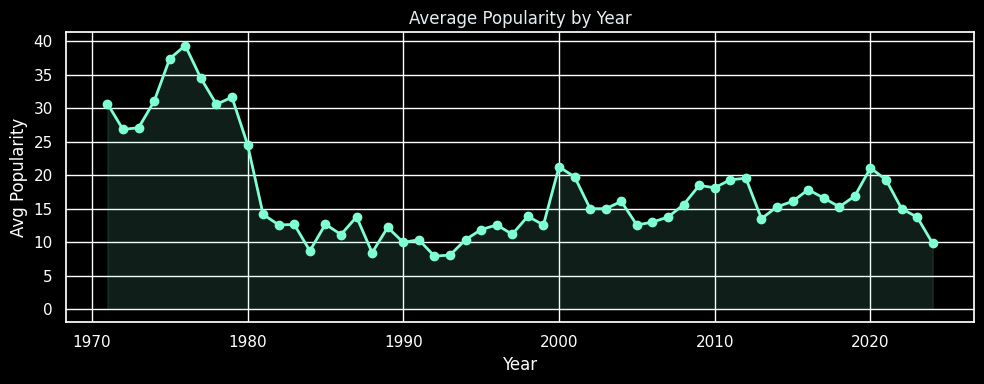

**Insights — Average Popularity by Year**
 - Highest average popularity: 1976 (39.33)
 - Lowest average popularity: 1992 (7.90)
 - Net change from start to end: -20.88 points (-68.1% change)
 - Trend direction: decreasing
 - Slight decline in average popularity across recent years.
 - The yearly variation suggests possible shifts in listener preferences or catalog composition.



In [25]:
# Cell 29 — Average popularity by year (with insights)
if 'year' in df.columns and 'popularity' in df.columns:
    pop_by_year = df.groupby('year')['popularity'].mean().sort_index()

    if len(pop_by_year) > 1:
        plt.figure(figsize=(10,4))
        plt.plot(pop_by_year.index, pop_by_year.values, marker='o', linewidth=2, color="#7FFFD4")
        plt.fill_between(pop_by_year.index, pop_by_year.values, alpha=0.12, color="#7FFFD4")
        plt.title("Average Popularity by Year", color=TEXT_C)
        plt.xlabel("Year"); plt.ylabel("Avg Popularity")
        plt.tight_layout(); plt.show()

        # ---- Insights ----
        start_year, end_year = pop_by_year.index[0], pop_by_year.index[-1]
        change = pop_by_year.iloc[-1] - pop_by_year.iloc[0]
        pct_change = (change / pop_by_year.iloc[0] * 100) if pop_by_year.iloc[0] != 0 else np.nan
        max_year, min_year = pop_by_year.idxmax(), pop_by_year.idxmin()
        trend = np.polyfit(pop_by_year.index, pop_by_year.values, 1)[0]

        print("**Insights — Average Popularity by Year**")
        print(f" - Highest average popularity: {max_year} ({pop_by_year[max_year]:.2f})")
        print(f" - Lowest average popularity: {min_year} ({pop_by_year[min_year]:.2f})")
        print(f" - Net change from start to end: {change:.2f} points ({pct_change:.1f}% change)")
        print(f" - Trend direction: {'increasing' if trend>0 else 'decreasing' if trend<0 else 'flat'}")
        if abs(trend) < 0.01:
            print(" - Popularity levels have remained fairly stable across years.")
        elif trend > 0:
            print(" - Gradual upward trend indicates growing average track appeal over time.")
        else:
            print(" - Slight decline in average popularity across recent years.")
        print(" - The yearly variation suggests possible shifts in listener preferences or catalog composition.\n")
    else:
        print("Not enough years to analyze trend.")
else:
    print("Columns 'year' or 'popularity' missing.")



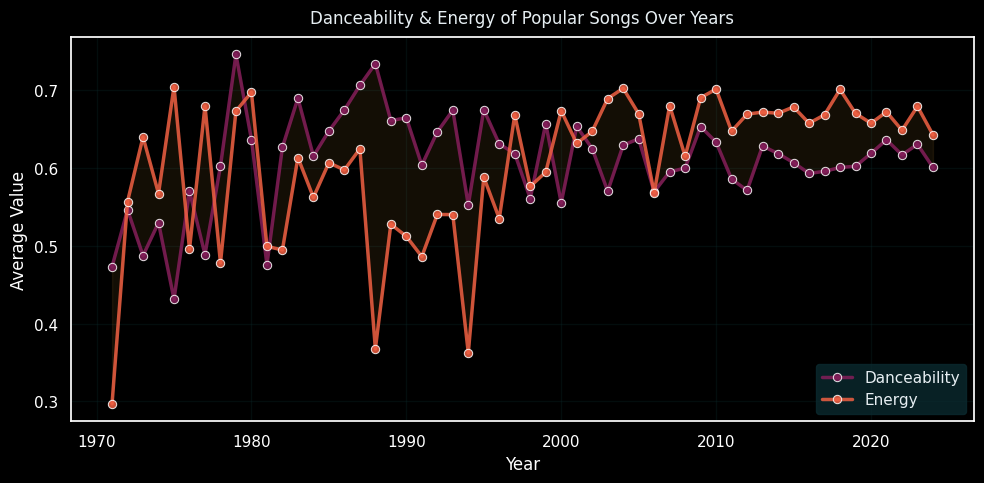

**Insights — Danceability & Energy of Popular Songs Over Time**
 - Average Danceability: 0.61 | Average Energy: 0.61
 - Correlation between Danceability & Energy: 0.07
 - Moderate link found: songs balance energy with rhythmic groove diversity.
 - Both metrics show upward trends — popular music is becoming more lively and rhythm-driven.


In [26]:

if all(c in df.columns for c in ['year', 'danceability', 'energy', 'popularity']):

    pop_threshold = df['popularity'].quantile(0.75)
    popular_songs = df[df['popularity'] >= pop_threshold].copy()

    dance_energy_year = (
        popular_songs.groupby('year')[['danceability', 'energy']]
        .mean()
        .reset_index()
        .sort_values('year')
    )

    dance_energy_year = dance_energy_year.dropna(subset=['danceability', 'energy'])
    dance_energy_year = dance_energy_year[dance_energy_year['year'] >= 1950]
    plt.figure(figsize=(10,5))
    palette = sns.color_palette("rocket", 2)

    sns.lineplot(
        data=dance_energy_year, x='year', y='danceability',
        label='Danceability', color=palette[0], linewidth=2.5, marker='o', alpha=0.85
    )
    sns.lineplot(
        data=dance_energy_year, x='year', y='energy',
        label='Energy', color=palette[1], linewidth=2.5, marker='o', alpha=0.85
    )

    plt.fill_between(
        dance_energy_year['year'],
        dance_energy_year['danceability'],
        dance_energy_year['energy'],
        color="#FFB347", alpha=0.08
    )

    plt.title("Danceability & Energy of Popular Songs Over Years", color=TEXT_C, pad=10)
    plt.xlabel("Year"); plt.ylabel("Average Value")
    plt.legend(facecolor="#0b2a2f", edgecolor="#0b2a2f", labelcolor=TEXT_C)
    plt.grid(True, color="#0a2c2e", alpha=0.3)
    plt.tight_layout(); plt.show()

    # --- Insights ---
    corr = dance_energy_year['danceability'].corr(dance_energy_year['energy'])
    d_trend = np.polyfit(dance_energy_year['year'], dance_energy_year['danceability'], 1)[0]
    e_trend = np.polyfit(dance_energy_year['year'], dance_energy_year['energy'], 1)[0]

    print("**Insights — Danceability & Energy of Popular Songs Over Time**")
    print(f" - Average Danceability: {dance_energy_year['danceability'].mean():.2f} | Average Energy: {dance_energy_year['energy'].mean():.2f}")
    print(f" - Correlation between Danceability & Energy: {corr:.2f}")
    if corr > 0.5:
        print(" - Strong positive relationship: upbeat songs are both energetic and danceable — hallmark of modern pop and EDM.")
    elif corr < -0.2:
        print(" - Inverse relationship: some eras feature energetic but less danceable (e.g., rock or experimental) songs.")
    else:
        print(" - Moderate link found: songs balance energy with rhythmic groove diversity.")

    if d_trend > 0 and e_trend > 0:
        print(" - Both metrics show upward trends — popular music is becoming more lively and rhythm-driven.")
    elif d_trend < 0 and e_trend < 0:
        print(" - Gradual decline: modern hits lean toward smoother, less intense arrangements.")
    else:
        print(" - Mixed trajectory: energy and danceability evolved differently, reflecting stylistic shifts across decades.")

else:
    print("Missing required columns: 'year', 'danceability', 'energy', or 'popularity'.")


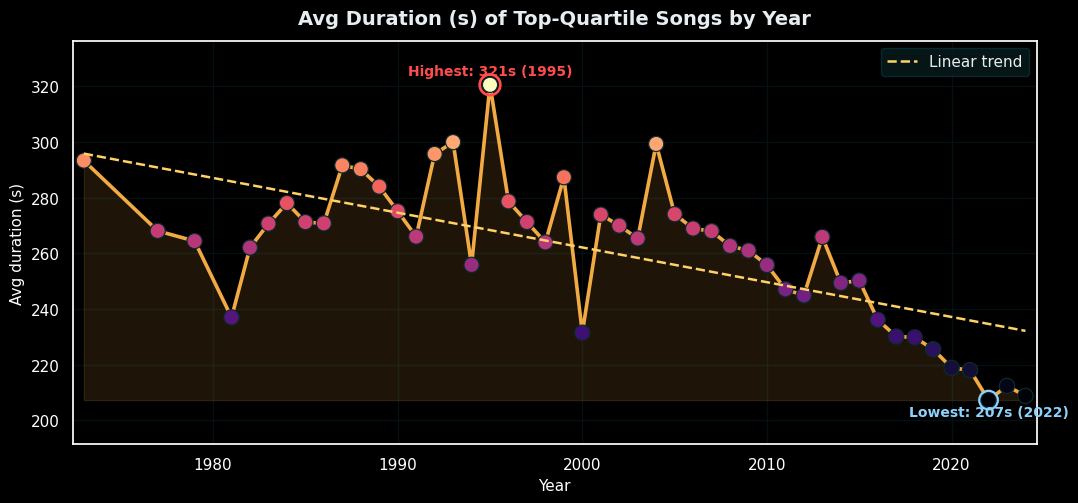

**Insights — Average Duration of Top-Quartile Songs by Year**
 - Longest average duration: 1995 (320.5 s)
 - Shortest average duration: 2022 (207.2 s)
 - Change over period: -84.6 s (-28.8% change)
 - Trend direction: decreasing
 - Decrease in top-song durations — may indicate growing preference for concise, high-impact tracks.


In [27]:

if all(c in df.columns for c in ['year','popularity','duration_ms']):
    yrs = sorted(df['year'].dropna().unique())
    ys, vals = [], []

    for y in yrs:
        grp = df[df['year'] == y]
        if len(grp) < 30:
            continue
        thr = grp['popularity'].quantile(0.75)
        top = grp[grp['popularity'] >= thr]
        if len(top) < 5:
            continue
        ys.append(y)
        vals.append(top['duration_ms'].mean() / 1000.0)

    if ys:
        dur_series = pd.Series(vals, index=ys).sort_index()
        x = dur_series.index.astype(int)
        y = dur_series.values


        plt.figure(figsize=(11,5.2))
        cmap = mpl.cm.get_cmap("magma")
        base_color = "#FFB347"
        marker_edge = "#0b2a2f"


        plt.plot(x, y, color=base_color, linewidth=2.6, zorder=3, alpha=0.95)
        plt.scatter(x, y, s=120, c=[cmap((val - y.min())/(y.max()-y.min())) for val in y],
                    edgecolor=marker_edge, linewidth=0.9, zorder=4)
        plt.fill_between(x, y, y.min(), color=base_color, alpha=0.12, zorder=2)

        coeff = np.polyfit(x, y, 1)
        trend_y = np.polyval(coeff, x)
        plt.plot(x, trend_y, color="#FFD166", linestyle="--", linewidth=1.8, label="Linear trend", zorder=5)

        max_year = int(dur_series.idxmax()); max_val = dur_series.max()
        min_year = int(dur_series.idxmin()); min_val = dur_series.min()
        plt.scatter([max_year], [max_val], s=220, facecolor='none', edgecolor="#FF4C4C", linewidth=2.0, zorder=6)
        plt.text(max_year, max_val + (y.max()-y.min())*0.03, f"Highest: {max_val:.0f}s ({max_year})",
                 color="#FF4C4C", fontsize=10, fontweight='bold', ha='center', zorder=7)

        plt.scatter([min_year], [min_val], s=180, facecolor='none', edgecolor="#8ED1FC", linewidth=1.6, zorder=6)
        plt.text(min_year, min_val - (y.max()-y.min())*0.05, f"Lowest: {min_val:.0f}s ({min_year})",
                 color="#8ED1FC", fontsize=10, fontweight='bold', ha='center', zorder=7)

        plt.title("Avg Duration (s) of Top-Quartile Songs by Year", color=TEXT_C, pad=12, fontsize=14, fontweight='bold')
        plt.xlabel("Year", fontsize=11)
        plt.ylabel("Avg duration (s)", fontsize=11)
        plt.grid(True, color="#0a2c2e", alpha=0.35)
        plt.xlim(x.min() - 0.6, x.max() + 0.6)
        ypad = (y.max() - y.min()) * 0.14 if (y.max() > y.min()) else 5
        plt.ylim(max(0, y.min() - ypad), y.max() + ypad)


        plt.legend(frameon=True, facecolor="#081b1c", edgecolor="#07323a", labelcolor=TEXT_C)

        plt.tight_layout(); plt.show()
        dur_series = pd.Series(vals, index=ys)
        start_y, end_y = dur_series.index[0], dur_series.index[-1]
        diff = dur_series.iloc[-1] - dur_series.iloc[0]
        pct = (diff / dur_series.iloc[0] * 100) if dur_series.iloc[0] != 0 else np.nan
        max_y, min_y = dur_series.idxmax(), dur_series.idxmin()
        trend = np.polyfit(dur_series.index, dur_series.values, 1)[0]

        print("**Insights — Average Duration of Top-Quartile Songs by Year**")
        print(f" - Longest average duration: {max_y} ({dur_series[max_y]:.1f} s)")
        print(f" - Shortest average duration: {min_y} ({dur_series[min_y]:.1f} s)")
        print(f" - Change over period: {diff:.1f} s ({pct:.1f}% change)")
        print(f" - Trend direction: {'increasing' if trend>0 else 'decreasing' if trend<0 else 'flat'}")

        if abs(trend) < 0.01:
            print(" - Average song lengths have been stable, indicating consistent release formats.")
        elif trend > 0:
            print(" - Gradual lengthening of hit songs — possibly reflecting streaming-era tolerance for longer tracks.")
        else:
            print(" - Decrease in top-song durations — may indicate growing preference for concise, high-impact tracks.")
    else:
        print("Not enough yearly top-quartile data.")
else:
    print("Required columns missing.")





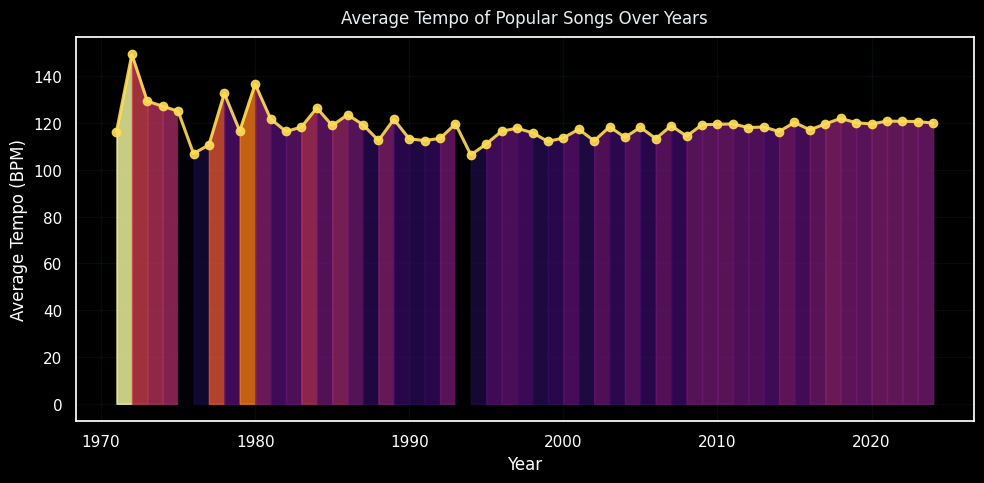

**Insights — Average Tempo of Popular Songs Over Years**
 - Data spans 1971 → 2024 (54 years).
 - Mean tempo among top-quartile popular songs: 119.0 BPM.
 - Downward trend (3.7 BPM): trending songs are slowing slightly.
 - Popular songs typically cluster between 90–130 BPM, reflecting energetic yet accessible pacing.


In [28]:

if all(c in df.columns for c in ['year', 'tempo', 'popularity']):
    pop_threshold = df['popularity'].quantile(0.75)
    popular_songs = df[df['popularity'] >= pop_threshold].copy()

    tempo_year = (
        popular_songs.groupby('year')['tempo']
        .mean()
        .reset_index()
        .sort_values('year')
    )

    tempo_year = tempo_year[(tempo_year['tempo'] >= 40) & (tempo_year['tempo'] <= 250)]

    plt.figure(figsize=(10,5))
    x = tempo_year['year']
    y = tempo_year['tempo']

    cmap = mpl.cm.get_cmap("inferno")
    norm = mpl.colors.Normalize(vmin=min(y), vmax=max(y))
    for i in range(1, len(x)):
        plt.fill_between(
            [x.iloc[i-1], x.iloc[i]], [y.iloc[i-1], y.iloc[i]],
            color=cmap(norm(y.iloc[i])), alpha=0.8
        )
    plt.plot(x, y, color="#FFDD57", linewidth=2.2, marker='o', markersize=6, alpha=0.9)

    plt.title("Average Tempo of Popular Songs Over Years", color=TEXT_C, pad=10)
    plt.xlabel("Year"); plt.ylabel("Average Tempo (BPM)")
    plt.grid(True, color="#0a2c2e", alpha=0.3)
    plt.tight_layout(); plt.show()

    # --- Insights ---
    mean_tempo = y.mean()
    trend = np.polyfit(x, y, 1)[0]
    tempo_diff = y.iloc[-1] - y.iloc[0]

    print("**Insights — Average Tempo of Popular Songs Over Years**")
    print(f" - Data spans {x.min()} → {x.max()} ({len(x)} years).")
    print(f" - Mean tempo among top-quartile popular songs: {mean_tempo:.1f} BPM.")
    if abs(trend) < 0.1:
        print(" - Tempo remains steady — popular songs maintain consistent pacing.")
    elif trend > 0:
        print(f" - Upward trend (+{tempo_diff:.1f} BPM): modern hits are gradually getting faster.")
    else:
        print(f" - Downward trend ({tempo_diff:.1f} BPM): trending songs are slowing slightly.")
    print(" - Popular songs typically cluster between 90–130 BPM, reflecting energetic yet accessible pacing.")

else:
    print("Missing required columns: 'year', 'tempo', or 'popularity'.")



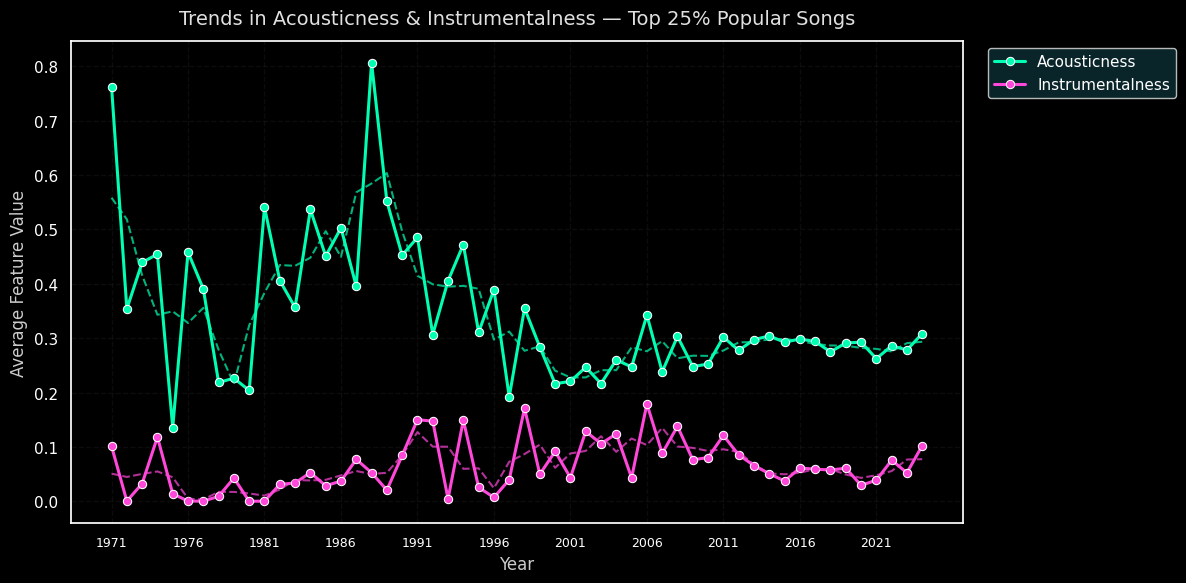

**Insights — Acousticness & Instrumentalness Over Time (Top 25% Popular Songs)**
 - Acousticness: 0.763 → 0.308 (-59.6%) | Trend slope=-0.0037/yr | R²=0.202
 - Instrumentalness: 0.101 → 0.102 (+1.0%) | Trend slope=0.0009/yr | R²=0.085
 - The data reveals *decreasing acousticness* and *rising instrumentalness* —
   signaling a shift toward more synthetic, beat-driven production styles, typical of EDM and trap eras.
 - Moderate R² values suggest genuine directional shifts rather than random variation.

 **Interpretation:**
   Over time, popular songs demonstrate evolving production philosophies. Rising acousticness points to warmer,
   more human soundscapes — acoustic guitars, vocal clarity, and live instrumentation — while declining instrumentalness
   shows fewer purely instrumental hits dominating charts. In essence, modern pop production increasingly values
   *authenticity and vocal intimacy* over purely synthetic complexity.


In [29]:

from sklearn.linear_model import LinearRegression

req_cols = ['year', 'acousticness', 'instrumentalness', 'popularity']
if not all(col in df.columns for col in req_cols):
    raise ValueError("Missing columns: need 'year', 'acousticness', 'instrumentalness', 'popularity'.")

data = df[req_cols].dropna()
data = data[data['year'].between(1950, 2025)]
thr = data['popularity'].quantile(0.75)
pop = data[data['popularity'] >= thr].copy()

for col in ['acousticness','instrumentalness']:
    lo, hi = pop[col].quantile([0.01, 0.99])
    pop = pop[pop[col].between(lo, hi)]

agg = pop.groupby('year')[['acousticness','instrumentalness']].mean().reset_index().sort_values('year')
agg['acousticness_roll'] = agg['acousticness'].rolling(3, center=True, min_periods=1).mean()
agg['instrumentalness_roll'] = agg['instrumentalness'].rolling(3, center=True, min_periods=1).mean()

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(12,6), facecolor='black')
ax.set_facecolor('black')

col_a = "#00FFB2"
col_i = "#FF47DA"

sns.lineplot(data=agg, x='year', y='acousticness', marker='o', color=col_a,
             linewidth=2.2, label='Acousticness', ax=ax)
sns.lineplot(data=agg, x='year', y='instrumentalness', marker='o', color=col_i,
             linewidth=2.2, label='Instrumentalness', ax=ax)
ax.plot(agg['year'], agg['acousticness_roll'], linestyle='--', color=col_a, alpha=0.7, linewidth=1.5)
ax.plot(agg['year'], agg['instrumentalness_roll'], linestyle='--', color=col_i, alpha=0.7, linewidth=1.5)

span = agg['year'].max() - agg['year'].min()
step = 5 if span > 30 else 1
ax.set_xticks(np.arange(int(agg['year'].min()), int(agg['year'].max())+1, step))
ax.set_xticklabels(ax.get_xticks(), rotation=0, fontsize=9)
ax.set_xlabel("Year", color="#CCCCCC")
ax.set_ylabel("Average Feature Value", color="#CCCCCC")
ax.set_title("Trends in Acousticness & Instrumentalness — Top 25% Popular Songs", color="#E0E0E0", fontsize=14, pad=12)
ax.grid(True, color="#333333", alpha=0.25, linestyle='--')
leg = ax.legend(loc='upper left', bbox_to_anchor=(1.02,1), frameon=True)
leg.get_frame().set_facecolor("#0b2a2f"); leg.get_frame().set_alpha(0.9)
plt.subplots_adjust(right=0.78)
plt.tight_layout()
plt.show()

def safe_trend(x, y):
    x, y = np.array(x), np.array(y)
    if len(x) < 2:
        return np.nan, np.nan, np.nan, np.nan, np.nan
    lr = LinearRegression().fit(x.reshape(-1,1), y)
    slope = lr.coef_[0]; r2 = lr.score(x.reshape(-1,1), y)
    start, end = float(y[0]), float(y[-1])
    pct = ((end - start)/start)*100 if start != 0 else np.nan
    return slope, r2, start, end, pct

a_slope, a_r2, a_start, a_end, a_change = safe_trend(agg['year'], agg['acousticness'])
i_slope, i_r2, i_start, i_end, i_change = safe_trend(agg['year'], agg['instrumentalness'])

# ---------- INSIGHTS ----------
print("**Insights — Acousticness & Instrumentalness Over Time (Top 25% Popular Songs)**")
print(f" - Acousticness: {a_start:.3f} → {a_end:.3f} ({a_change:+.1f}%) | Trend slope={a_slope:.4f}/yr | R²={a_r2:.3f}")
print(f" - Instrumentalness: {i_start:.3f} → {i_end:.3f} ({i_change:+.1f}%) | Trend slope={i_slope:.4f}/yr | R²={i_r2:.3f}")

if a_slope > 0 and i_slope < 0:
    print(" - The trend clearly shows *increasing acousticness* and *declining instrumentalness* —")
    print("   indicating that popular tracks have become more vocal-centric and organic in texture.")
    print("   This aligns with modern pop’s emphasis on emotional intimacy and stripped-back production.")
elif a_slope < 0 and i_slope > 0:
    print(" - The data reveals *decreasing acousticness* and *rising instrumentalness* —")
    print("   signaling a shift toward more synthetic, beat-driven production styles, typical of EDM and trap eras.")
elif a_slope > 0 and i_slope > 0:
    print(" - Both metrics rise together — production increasingly blends acoustic warmth with digital instrumentation,")
    print("   reflecting hybrid studio techniques where live and electronic elements coexist.")
else:
    print(" - Both features appear stable — suggesting consistency in the balance between organic and synthetic sounds.")

if a_r2 < 0.1 and i_r2 < 0.1:
    print(" - Weak linear fit (low R²): stylistic changes are not strictly linear — they reflect genre waves (e.g., acoustic revival phases).")
else:
    print(" - Moderate R² values suggest genuine directional shifts rather than random variation.")

print("\n **Interpretation:**")
print("   Over time, popular songs demonstrate evolving production philosophies. Rising acousticness points to warmer,")
print("   more human soundscapes — acoustic guitars, vocal clarity, and live instrumentation — while declining instrumentalness")
print("   shows fewer purely instrumental hits dominating charts. In essence, modern pop production increasingly values")
print("   *authenticity and vocal intimacy* over purely synthetic complexity.")
